In [1]:
%pip install tensorflow opencv-python matplotlib kagglehub pandas tensorflow_hub scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shreelakshmigp/cedardataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Satgu\.cache\kagglehub\datasets\shreelakshmigp\cedardataset\versions\1


In [3]:
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

Load Data

In [4]:
def load_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = img.reshape(-1)
    return img

def create_dataset(path, path_to_class1, path_to_class2):
    X = []
    y = []
    for img_path in os.listdir(os.path.join(path, path_to_class1)):
        if img_path[-3:] in {'jpg', 'png'}:
            img = load_img(os.path.join(path, path_to_class1, img_path))
            X.append(img)
            y.append(0)

    for img_path in os.listdir(os.path.join(path, path_to_class2)):
        if img_path[-3:] in {'jpg', 'png'}:
            img = load_img(os.path.join(path, path_to_class2, img_path))
            X.append(img)
            y.append(1)
    
    return X, y

X, y = create_dataset(os.path.join(path, 'signatures'), 'full_forg', 'full_org')

In [5]:
X[:4]

[array([255, 255, 255, ..., 251, 251, 251], dtype=uint8),
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8),
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8),
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)]

In [6]:
y[-4:]

[1, 1, 1, 1]

Test Train Split

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,shuffle=True,test_size=0.25,random_state=245)

Building the model

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [9]:
models = [GaussianNB(), LogisticRegression(max_iter=2**16), SVC(), KNeighborsClassifier()]

Training the model

In [10]:
hist = []
for model in models:
    hist.append(model.fit(x_train, y_train))

Performance Evaluation

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve, confusion_matrix

In [16]:
def ModelEvaluation(model, x_test, y_test):
    print(model)
    predictions = model.predict(x_test)
    accuracy = accuracy_score(predictions, y_test)
    precision = precision_score(predictions, y_test)
    recall = recall_score(predictions, y_test)
    print("Accuracy: ", accuracy)
    print("Recall: ", recall)
    print("Precision: ", precision)
    auc = roc_auc_score(y_test,predictions)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, predictions)
    print('ROC_AUC_SCORE is', auc)


    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    sns.heatmap(confusion_matrix(y_test, predictions), fmt='', annot=True)

GaussianNB()
Accuracy:  0.996969696969697
Recall:  0.9943181818181818
Precision:  1.0
ROC_AUC_SCORE is 0.996774193548387


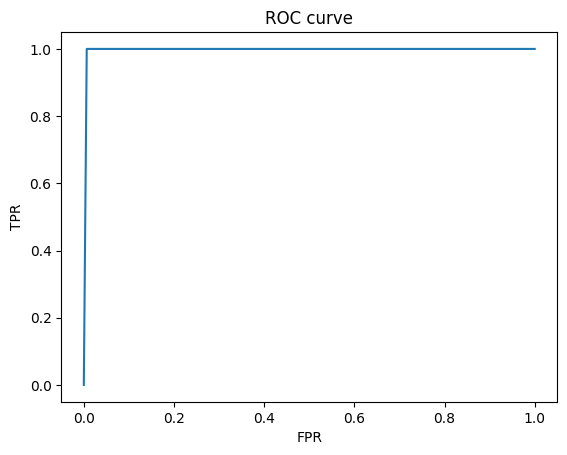

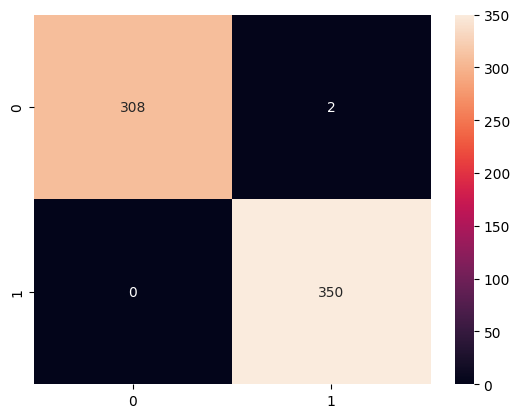

In [ ]:
ModelEvaluation(models[0], x_test, y_test)

LogisticRegression(max_iter=65536)
Accuracy:  0.8045454545454546
Recall:  0.8259587020648967
Precision:  0.8
ROC_AUC_SCORE is 0.8048387096774194


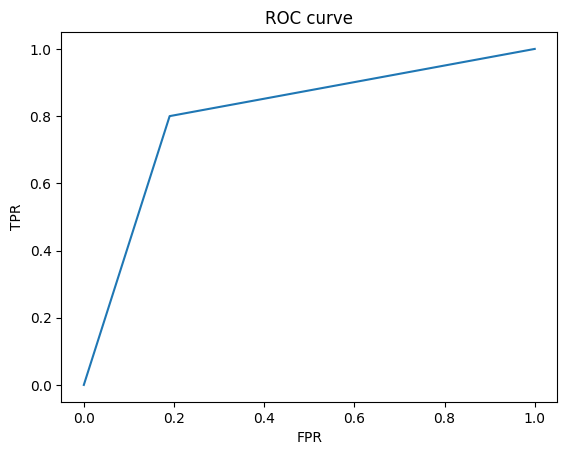

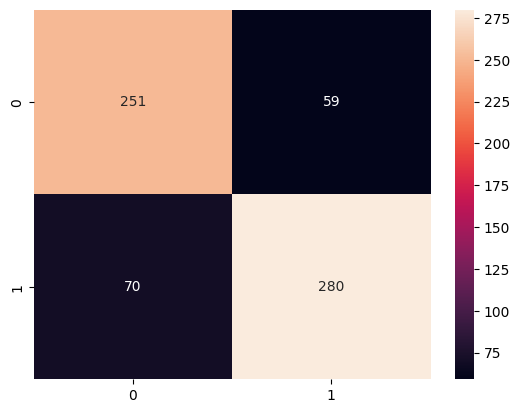

In [ ]:
ModelEvaluation(models[1], x_test, y_test)

SVC()
Accuracy:  0.9939393939393939
Recall:  1.0
Precision:  0.9885714285714285
ROC_AUC_SCORE is 0.9942857142857142


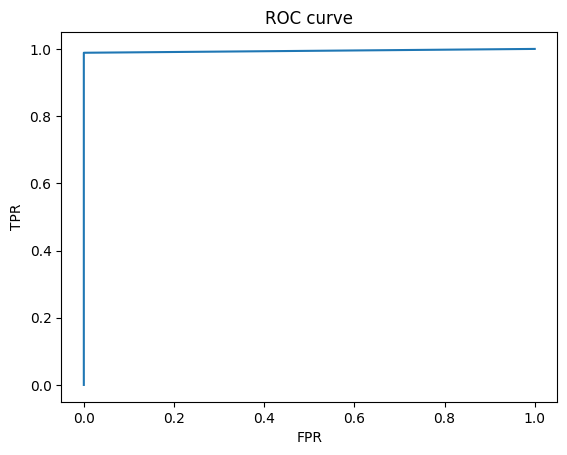

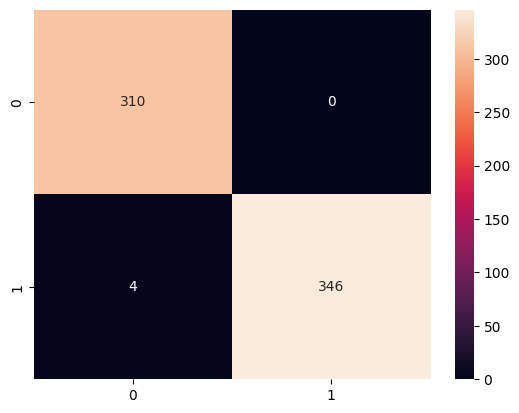

In [18]:
ModelEvaluation(models[2], x_test, y_test)

KNeighborsClassifier()
Accuracy:  0.9
Recall:  0.8413461538461539
Precision:  1.0
ROC_AUC_SCORE is 0.8935483870967742


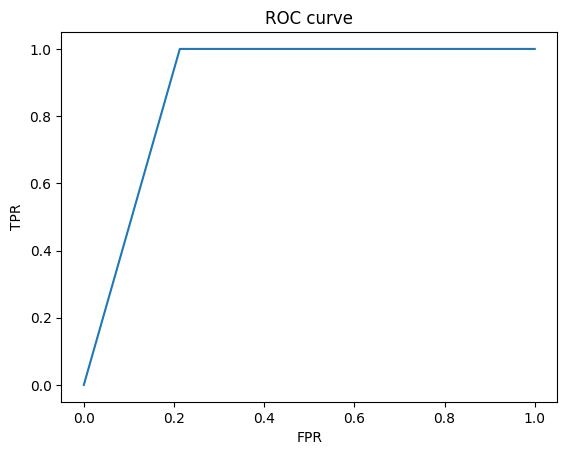

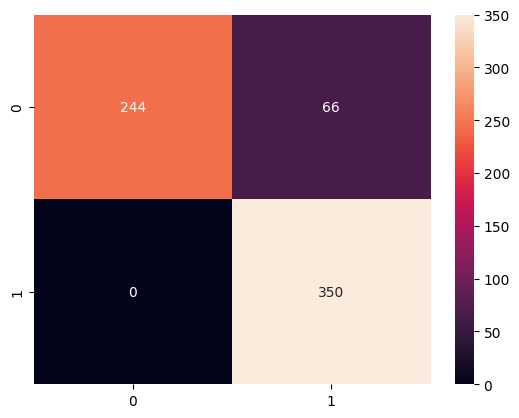

In [19]:
ModelEvaluation(models[3], x_test, y_test)

Saving the model

In [20]:
import pickle

In [21]:
filepath = os.path.join(os.getcwd(), 'models', 'forgery_model.sav')
pickle.dump(model, open(filepath, 'wb'))

Loading the model

In [22]:
import pickle

In [23]:
filepath = os.path.join(os.getcwd(), 'models', 'forgery_model.sav')
loaded_model = pickle.load(open(filepath, 'rb'))

In [24]:
loaded_model.predict([load_img('forgeries_1_14.png'), load_img('original_3_6.png')])

array([0, 1])

Testing against NST Forgeries (Run NST.ipynb before proceeding)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve, confusion_matrix

In [26]:
path = "Files"


def create_dataset(path, path_to_class1, path_to_class2):
    X = []
    y = []
    for img_path in os.listdir(os.path.join(path, path_to_class1)):
        if img_path[-3:] in {'jpg', 'png'}:
            img = load_img(os.path.join(path, path_to_class1, img_path))
            X.append(img)
            y.append(0)

    for img_path in os.listdir(os.path.join(path, path_to_class2)):
        if img_path[-3:] in {'jpg', 'png'}:
            img = load_img(os.path.join(path, path_to_class2, img_path))
            X.append(img)
            y.append(1)
    
    return X, y

"""
# legacy
def load_data(path, X):
    for filename in os.listdir(path):
        print(os.path.join(path, filename))
        img = load_img(os.path.join(path, filename))
        print(img)
        X.append(img)
"""

'\n# legacy\ndef load_data(path, X):\n    for filename in os.listdir(path):\n        print(os.path.join(path, filename))\n        img = load_img(os.path.join(path, filename))\n        print(img)\n        X.append(img)\n'

In [27]:
X_NST, y_NST = create_dataset(path, "forged", "originals")

GaussianNB()
Accuracy:  0.5
Recall:  0.5
Precision:  1.0
ROC_AUC_SCORE is 0.5


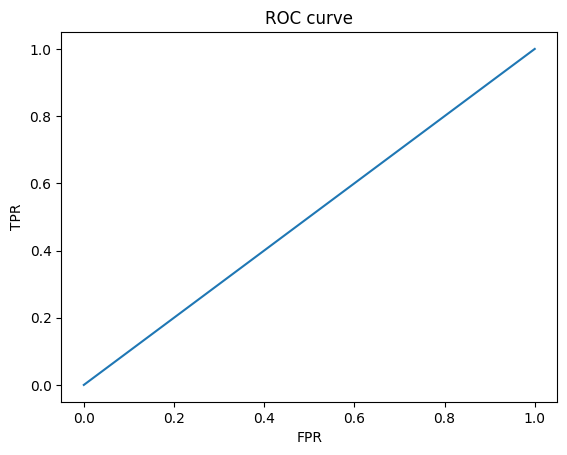

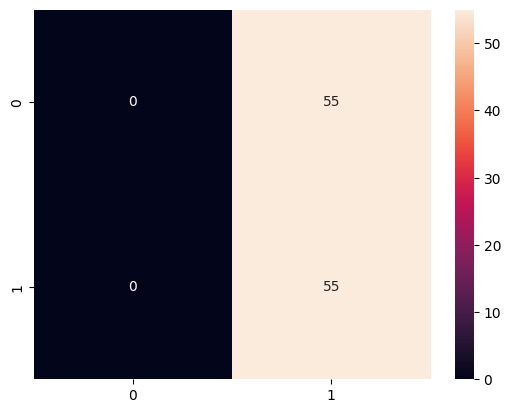

In [28]:
ModelEvaluation(models[0], X_NST, y_NST)

LogisticRegression(max_iter=65536)
Accuracy:  0.44545454545454544
Recall:  0.47115384615384615
Precision:  0.8909090909090909
ROC_AUC_SCORE is 0.44545454545454544


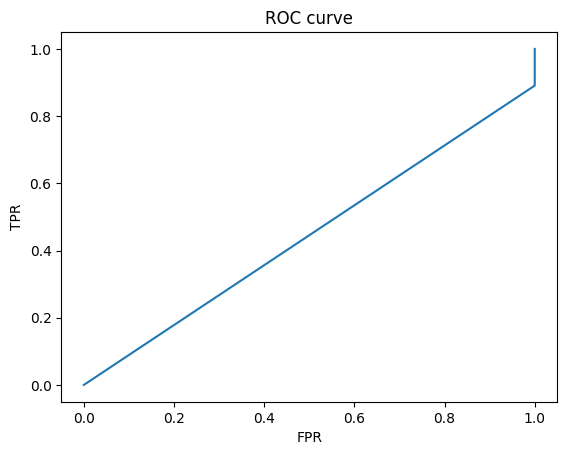

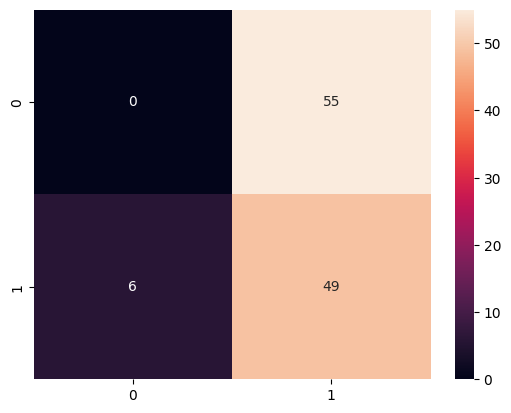

In [29]:
ModelEvaluation(models[1], X_NST, y_NST)

SVC()
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
ROC_AUC_SCORE is 1.0


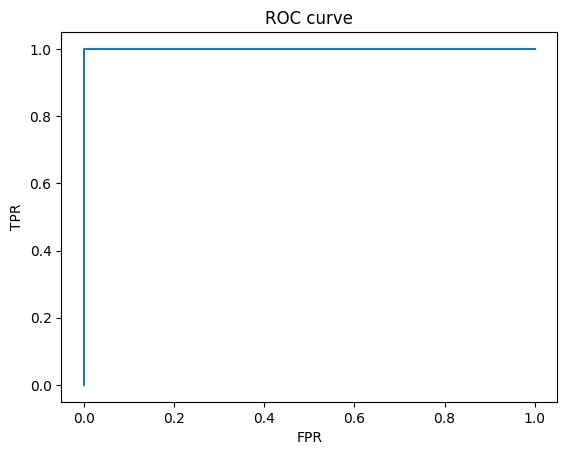

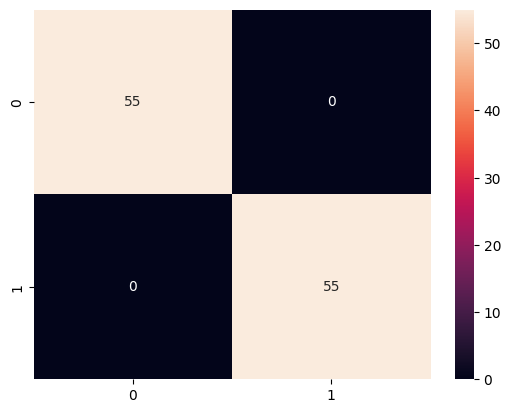

In [30]:
ModelEvaluation(models[2], X_NST, y_NST)

KNeighborsClassifier()
Accuracy:  0.5
Recall:  0.5
Precision:  1.0
ROC_AUC_SCORE is 0.5


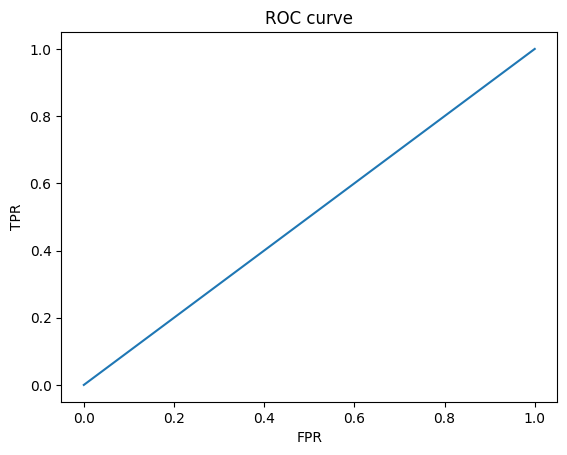

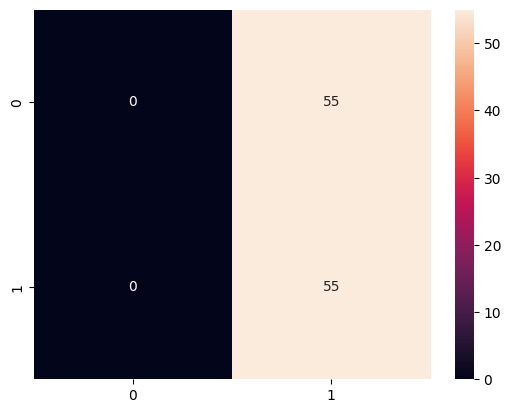

In [31]:
ModelEvaluation(models[3], X_NST, y_NST)